In [1]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get('https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css')
    return HTML(styles.text)
css_styling()

# Lid-Driven Cavity Flow
## Vorticity - Streamfunction Formulation
From Tony Saad's uCFD course given at the University of Utah (<a>tonysaad.net<a>)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['animation.html'] = 'html5'

In [34]:
# Domain parameters
nx = 33
ny = 33
Lx = 1.
Ly = 1.
dx = Lx/(nx-1)
dy = Ly/(ny-1)

In [35]:
# Boundary velocities
Ut = 10.   # U top wall
Ub = 0.   # U bottom wall
Vl = 0.   # V left wall
Vr = 0.   # V right wall

In [36]:
ψ0 = np.zeros((ny, nx))
ω0 = np.zeros((ny, nx))

# Apply boundary conditions on vorticity (from Taylor Series expansion for streamfunction on wall)
## Vorticity on the left wall
ω0[1:-1,0] = 2./dx**2 * (ψ0[1:-1,0]-ψ0[1:-1,1]) + 2./dx*Vl
## Vorticity on right wall
ω0[1:-1,-1] = 2./dx**2 * (ψ0[1:-1,-1]-ψ0[1:-1,-2]) - 2./dx*Vr
## Vorticity on bottom wall
ω0[0,1:-1] = 2./dy**2 * (ψ0[0,1:-1]-ψ0[1,1:-1]) + 2./dy*Ub
## Vorticity on top wall
ω0[-1,1:-1] = 2./dy**2 * (ψ0[-1,1:-1]-ψ0[-2,1:-1]) - 2./dy*Ut

t = 0.

tol = 1e-3
β = 1.5
maxit = 30
ν = 5e-2
# Set dt from stability conditions
dt = min(0.25*dx*dx/ν, 4*ν/Ut/Ut)
tend = 1000*dt

# Create empty lists for animations
psisol = []
psisol.append(ψ0)
omegasol = []
omegasol.append(ω0)

print(ν*dt/dx**2 < 0.25)
print(2.*Ut*dt/ν < 2)
print(f'dt = {dt:0.3f}')
print(f'Re = {Ut*Lx/ν:0.3f}')

True
True
dt = 0.002
Re = 200.000


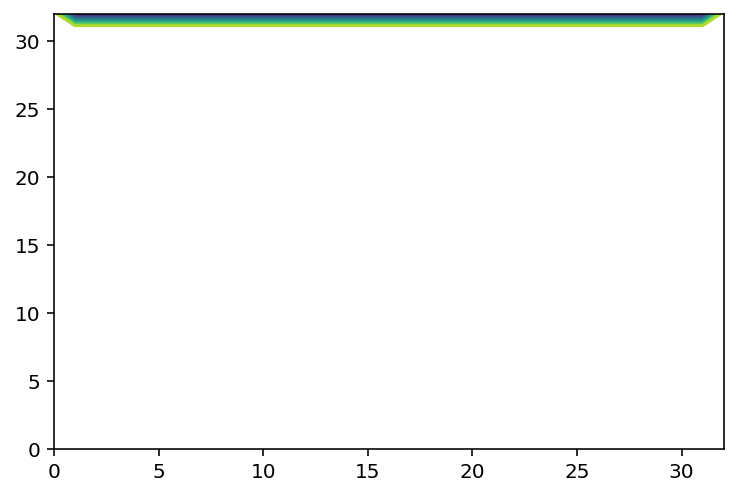

In [37]:
plt.contour(ω0)

The only vorticity that exists initially is at the top boundary, which has a velocity. In effect, vorticity is being "injected" into the domain from the top boundary. The algorithm for the solution is:

- Solve for streamfunction using explicit method and existing vorticity (Poisson equation)
- Solve the vorticity transport equation
- Repeat

In [38]:
while t < tend:
    # Start by solving the Poisson equation for the streamfunction
    it = 0
    err = 1e5
    ωn = omegasol[-1]
    ψ = np.copy(psisol[-1]) 
    # Iterate over streamfunction poisson equation
    while err > tol and it < maxit:
        ψk = np.zeros_like(ψ)
        ψk[1:-1,1:-1] = ψ[1:-1,1:-1]
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                rhs = (dx*dy)**2*ωn[j,i] + dy**2*(ψ[j,i+1]+ψ[j,i-1]) + dx**2*(ψ[j+1,i]+ψ[j-1,i])
                rhs *= β/2/(dx**2 + dy**2)
                ψ[j,i] = rhs + (1.-β)*ψ[j,i]
        err = np.linalg.norm(ψ.ravel() - ψk.ravel())  # Flattening the array makes the norm more intuitive
        it += 1
    psisol.append(ψ)
    
    # Solve for vorticity
    ω = np.zeros_like(ωn)
    
    # Convection terms
    Cx = -(ψ[2:,1:-1] - ψ[:-2,1:-1])/2./dy * (ωn[1:-1,2:]-ωn[1:-1,:-2])/2./dx
    Cy = (ψ[1:-1,2:] - ψ[1:-1,:-2])/2./dx * (ωn[2:,1:-1]-ωn[:-2,1:-1])/2./dy
    
    # Diffusion
    Dx = (ωn[1:-1,2:] - 2.*ωn[1:-1,1:-1] + ωn[1:-1,:-2])/dx/dx
    Dy = (ωn[2:,1:-1] - 2.*ωn[1:-1,1:-1] + ωn[:-2,1:-1])/dy/dy
    
    rhs = Cx + Cy + ν*(Dx + Dy)
    ω[1:-1,1:-1] = ωn[1:-1,1:-1] + dt * rhs
    
    
    # apply boundary conditions on vorticity
    ## Vorticity on the left wall
    ω[1:-1,0] = 2./dx**2 * (ψ[1:-1,0]-ψ[1:-1,1]) + 2./dx*Vl
    ## Vorticity on right wall
    ω[1:-1,-1] = 2./dx**2 * (ψ[1:-1,-1]-ψ[1:-1,-2]) - 2./dx*Vr
    ## Vorticity on bottom wall
    ω[0,1:-1] = 2./dy**2 * (ψ[0,1:-1]-ψ[1,1:-1]) + 2./dy*Ub
    ## Vorticity on top wall
    ω[-1,1:-1] = 2./dy**2 * (ψ[-1,1:-1]-ψ[-2,1:-1]) - 2./dy*Ut
    
    omegasol.append(ω)
    
    t += dt

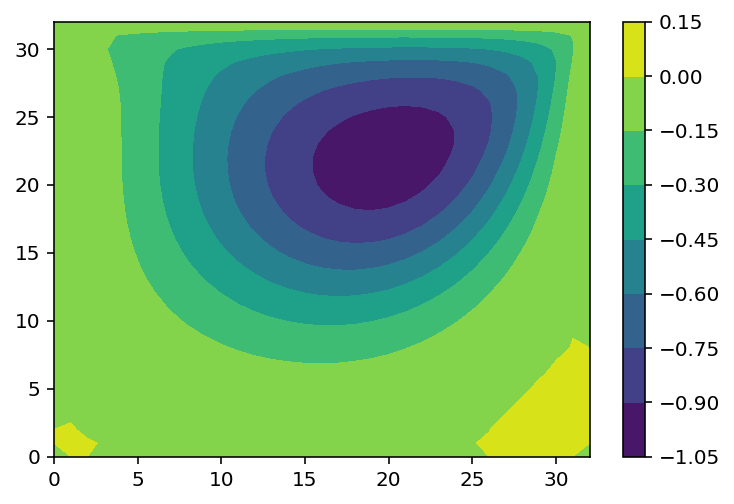

In [39]:
plt.contourf(psisol[-1])
plt.colorbar()

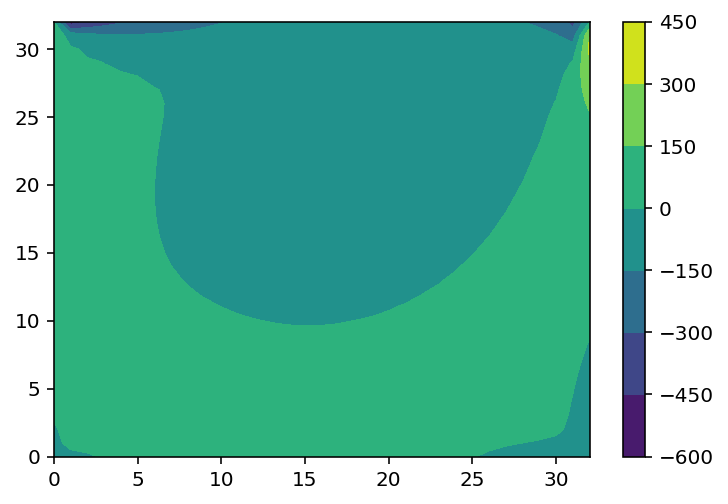

In [40]:
plt.contourf(omegasol[-1])
plt.colorbar()

Now, it's time to make a higher quality plot of the velocity, along with plotting the streamlines of the flow. One other check we need to make is that the solution is divergence-free (of the velocity).

In [41]:
x = np.linspace(0, Lx, nx)
y = np.linspace(0, Ly, ny)
xx, yy = np.meshgrid(x, y)
nn = 1
ψ = psisol[-1]
# Centered differences for the velocities based on the streamfunction
u = (ψ[2:,1:-1]-ψ[:-2,1:-1])/2./dy
v = -(ψ[1:-1,2:]-ψ[1:-1,:-2])/2./dx
divu = (u[1:-1,2:]-u[1:-1,:-2])/2./dx
divv = (v[2:,1:-1]-v[:-2,1:-1])/2./dy
print(f'Divergence: {np.abs(divu+divv).max()}')

Divergence: 1.0658141036401503e-14


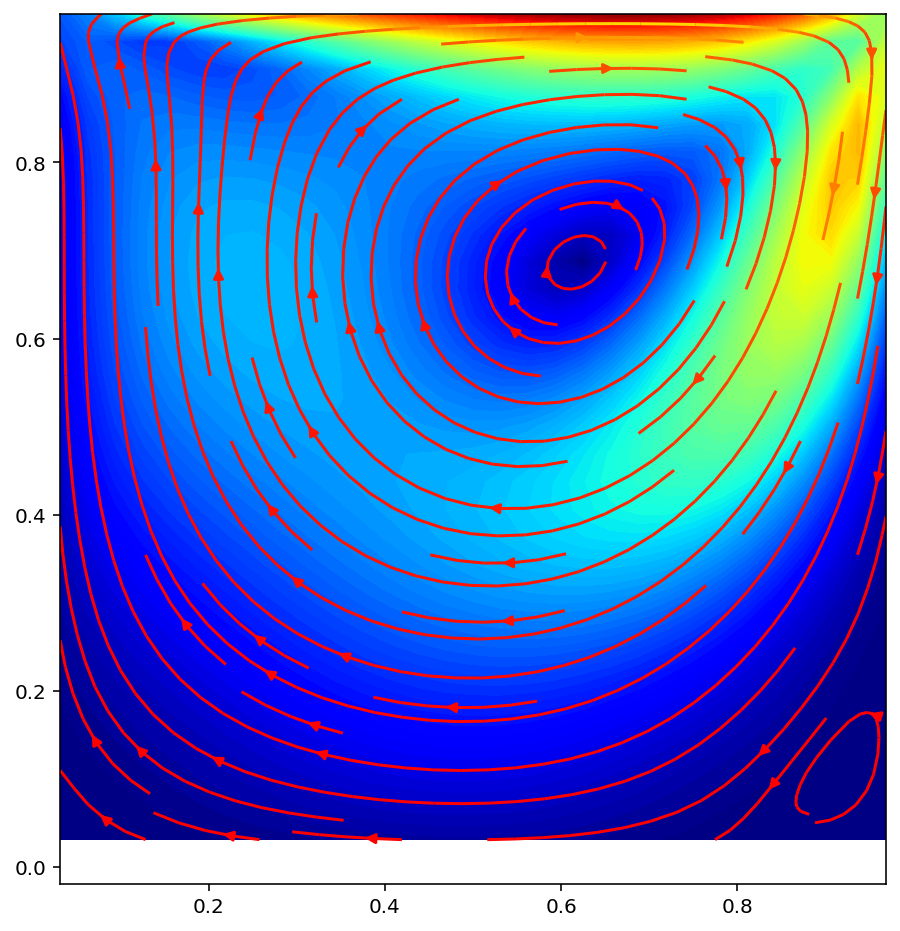

In [44]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.contourf(xx[1:-1,1:-1], yy[1:-1,1:-1], np.sqrt(u*u+v*v), levels=100, cmap=plt.cm.jet)
ax.streamplot(xx[1:-1,1:-1], yy[1:-1,1:-1], u, v, color=np.abs(u*u+v*v),cmap=plt.cm.autumn)
ax.set_xlim([xx[0,1],xx[0,-2]])
#ax.set_ylim([yy[0,1],yy[0,-2]])
ax.set_aspect(1)

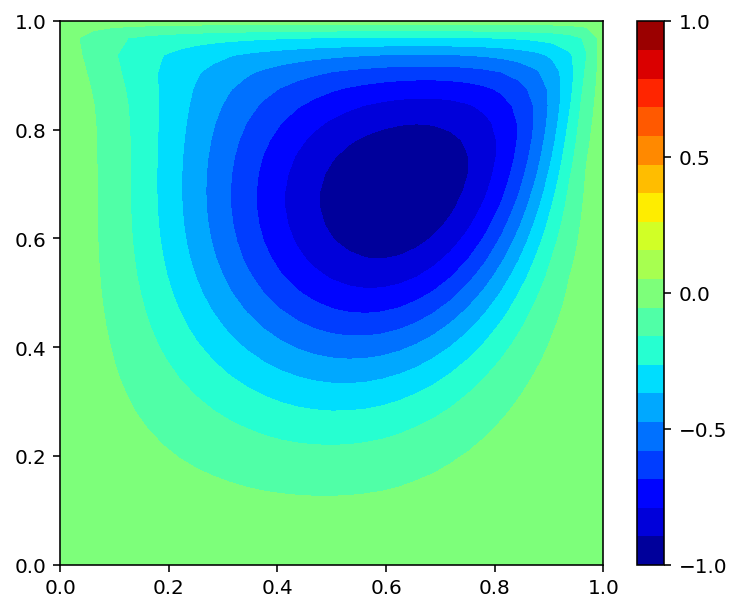

In [51]:
ims = []
fig = plt.figure(figsize=(6.1,5), facecolor='w')
levs = np.linspace(-1,1,20)
t = 0.0
i = 0
for solution in psisol:
    if (i%10==0): # output frequency for frames  
        im = plt.contourf(xx,yy,solution,cmap=cm.jet, levels=levs)
        ims.append(im.collections)
    i+=1
    t += dt

cbar = plt.colorbar()
plt.clim(-1,1)
cbar.set_ticks(np.linspace(-1,1,5))
ani = animation.ArtistAnimation(fig, ims, interval=35, blit=True,
                                repeat_delay=1000)
# ani.save('ftus.mp4')   
ani

In [46]:
xx.shape

(33, 33)

In [47]:
psisol[0].shape

(33, 33)

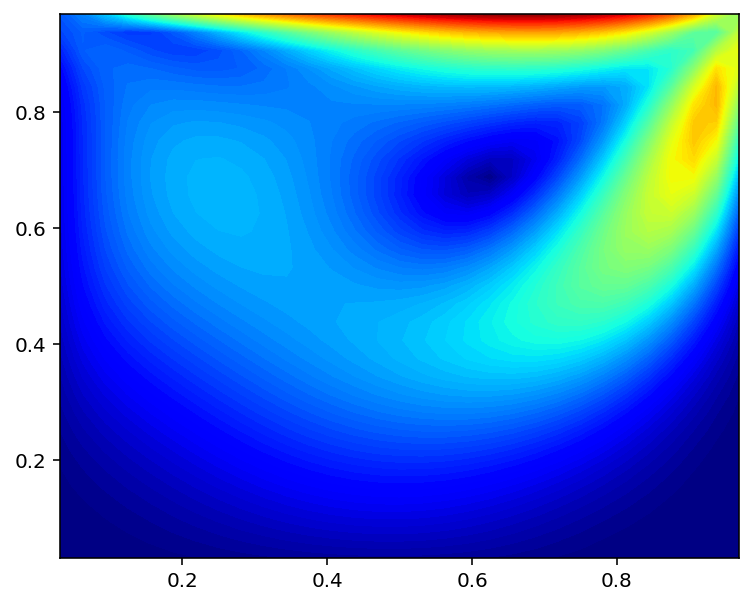

In [57]:
ims = []
fig = plt.figure(figsize=(6.1,5), facecolor='w')
levs = np.linspace(-1,1,20)
t = 0.0
i = 0
for solution in psisol:
    u = (solution[2:,1:-1]-solution[:-2,1:-1])/2./dy
    v = -(solution[1:-1,2:]-solution[1:-1,:-2])/2./dx
    if (i%5==0): # output frequency for frames
        im = plt.contourf(xx[1:-1,1:-1], yy[1:-1,1:-1], np.sqrt(u*u+v*v), levels=100, cmap=plt.cm.jet)
        #ax.set_xlim([xx[0,1],xx[0,-2]])
        ims.append(im.collections)
    i+=1
    t += dt

ani = animation.ArtistAnimation(fig, ims, interval=35, blit=True,
                                repeat_delay=1000)
# ani.save('vel-vort-sf.mp4')   
ani